# Generator attack sustainability

Suppose a leakange in our train data occured. Given a generator (or generated samples), an adversary is able to restore the train set. So it is significant to make our generator sustainable to those attacks. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd

In [2]:
import os

GDRIVE_PATH = '/data/apsidorenko'
THIS_EXERCISE_PATH = os.path.join(GDRIVE_PATH, "GAN_exercises")
MODELS_HOME = os.path.join(THIS_EXERCISE_PATH, "mnist guns")

In [3]:
os.makedirs(THIS_EXERCISE_PATH, exist_ok=True)
os.makedirs(MODELS_HOME, exist_ok=True)

In [4]:
leakage_share = 0.2

In [5]:
df = pd.read_csv('https://query.data.world/s/nap7jvxtupud25z5ljvtbzzjjsqqay')
df.head()

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_774,column_775,column_776,column_777,column_778,column_779,column_780,column_781,column_782,column_783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
target = pd.read_csv('https://query.data.world/s/sn3dximsq5sw3a6wtqoc3okulevugz')
target.head()

,column_0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [7]:
from sklearn.model_selection import train_test_split
train, test, tar_train, tar_test = train_test_split(df, target, test_size=0.2, random_state=12345)

In [8]:
train = np.array(train, dtype='float')
test = np.array(test, dtype='float')
tar_train = np.array(tar_train, dtype='float')
tar_test = np.array(tar_test, dtype='float')

In [9]:
train= train.reshape((-1, 1, 28, 28)) / 255.
test= test.reshape((-1, 1, 28, 28)) / 255.

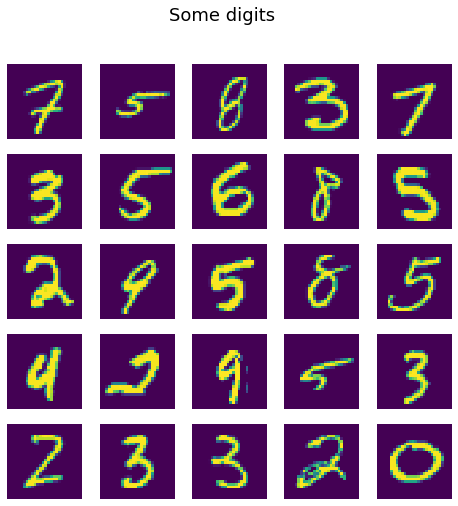

In [10]:
def plot_images(images: np.ndarray,
                nrows: int=5, ncols: int=5,
                shuffle: bool=True,
                title: str="",
                figure: matplotlib.figure.Figure=None) -> matplotlib.figure.Figure:
  """
  Plots a subset of images.
  
  Args:
    images[n_images, n_channels, width, height]: a dataset with images to plot
    nrows: number of images in a plotted row
    ncols: numer of images in a plotted colunm
    shuffle: if True draw a random subset of images, if False -- the first ones
    figure: if not None, it's used for plotting, if None, a new one is created
  
  Returns:
    a figure containing the plotted images
  """
  if shuffle:
    images_to_plot = images[np.random.permutation(len(images))[:nrows*ncols]]
  else:
    images_to_plot = images[:nrows * ncols]
  h, w = images_to_plot.shape[2:]
  if figure is None:
    figure = plt.figure(figsize=(8,8))
  
  axes = figure.subplots(nrows=nrows, ncols=ncols)
  for row_idx, ax_row in enumerate(axes):
    for col_idx, ax in enumerate(ax_row):
      ax.imshow(images_to_plot[row_idx + ncols*col_idx, 0],
                interpolation="none")
      ax.set_axis_off()

  figure.suptitle(title, fontsize=18)
  return figure

plot_images(train, title="Some digits");

# Building GAN

In [11]:
import torch
from torch import nn
from torch.nn.functional import logsigmoid

class Reshape(torch.nn.Module):
  """
  Reshapes a tensor starting from the 1st dimension (not 0th),
  i. e. without influencing the batch dimension.
  """
  def __init__(self, *shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(x.shape[0], *self.shape)
  
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [12]:
GENERATOR_FILE = os.path.join(MODELS_HOME, 'generator_sustain.pt')
GENERATOR_FILE_LOAD = os.path.join(MODELS_HOME, 'generator_other.pt')
DISCRIMINATOR_FILE = os.path.join(MODELS_HOME, 'discriminator_sustain.pt')

In [13]:
CODE_SIZE = 256
DROPOUT_RATE = 0.1

try:
  generator = torch.load(GENERATOR_FILE_LOAD)
  #discriminator = torch.load(DISCRIMINATOR_FILE)
except FileNotFoundError:
 print('FUUUUUU!')


In [14]:
def sample_fake(batch_size):
  noise = torch.randn(batch_size, CODE_SIZE, device="cuda")
  return generator(noise)

In [15]:
# A small check that the generator output has the right size
test_generated_data = sample_fake(1)
assert tuple(test_generated_data.shape[1:]) == train.shape[1:]

In [16]:
def sample_images(batch_size, train=train):
  ids = np.random.choice(len(train), size=batch_size)
  return torch.tensor(train[ids], device="cuda").float()

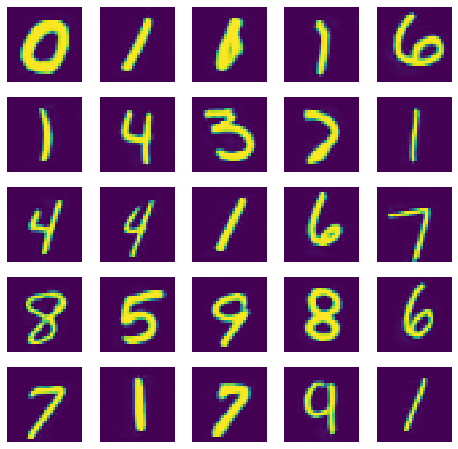

In [17]:
generator.eval()
imgs = sample_fake(25).cpu().detach().numpy()
plot_images(imgs.clip(0, 1));

Now suppose we have no discriminator, but we have some part of the train set

In [18]:
np.random.seed(1234567)

In [19]:
n_leak = round(train.shape[0] * leakage_share)

In [20]:
train_leak = train[np.random.permutation(train.shape[0])]
train_check = train_leak[n_leak:]
train_leak = train_leak[0:n_leak]

In [21]:
train_leak.shape

(11200, 1, 28, 28)

In [22]:
def give_new_disc():
    net = nn.Sequential(
           #Reshape(1, 28,28),
           torch.nn.Conv2d(1, 8, kernel_size=3, padding=1),
           torch.nn.ELU(),
           torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.MaxPool2d(2), # 18x18
      
            torch.nn.Conv2d(8, 32, kernel_size=3, padding=1),
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.MaxPool2d(2), # 9x9
      
            torch.nn.Conv2d(32, 64, kernel_size=3), # 7x7
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.Conv2d(64, 256, kernel_size=3), # 5x5
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
            torch.nn.Conv2d(256, 512, kernel_size=3), # 3x3
            torch.nn.ELU(),
            torch.nn.Dropout(p=DROPOUT_RATE),
      
             Reshape(512),
             torch.nn.Linear(512, 1)
    ).cuda()
    return net

In [23]:
noise_power = 0.3
gradient_penalty = 0.0001

def generator_loss(fake):
  return -logsigmoid(discriminator(
              fake + torch.randn(*fake.shape, device="cuda") * noise_power
          )).mean()
  
  
def discriminator_loss(real, fake):
  return -logsigmoid(discriminator(
              real + torch.randn(*real.shape, device="cuda") * noise_power
          )).mean() - \
          logsigmoid(-discriminator(
              fake + torch.randn(*fake.shape, device="cuda") * noise_power
          )).mean()

def discriminator_penalty(real, size=gradient_penalty):
  scores = discriminator(real)
  grad_params = torch.autograd.grad(scores.mean(), discriminator.parameters(),
                                    create_graph=True)
  penalty = sum((grad**2).sum() for grad in grad_params)
  return penalty * size

In [24]:
optimizer_generator = \
    torch.optim.RMSprop(generator.parameters(), lr=0.001)

gen_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_generator, step_size=10, gamma=0.999)

In [25]:
VALIDATION_INTERVAL = 250
SAVE_INTERVAL = 500
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
BATCH_SIZE=128

In [26]:
losses = np.zeros(VALIDATION_INTERVAL)

In [27]:
test_leak = np.concatenate((train_check[np.random.permutation(train_check.shape[0])][0:1000], 
                            sample_fake(1000).cpu().detach().numpy()), axis=0)

In [28]:
not_were_in_train = test[np.random.permutation(test.shape[0])][0:500]

In [29]:
complicated_test = np.concatenate((train_check[np.random.permutation(train_check.shape[0])][1000:2000], 
                            sample_fake(500).cpu().detach().numpy(), not_were_in_train), axis=0)

In [30]:
totals = np.zeros(6)
totals_2 = np.zeros(6)

In [31]:
def make_a_test(k):
    ans = discriminator(torch.tensor(test_leak).float().cuda()).cpu().detach().numpy().reshape(-1)
    labels = np.array([x < 1000 for x in range(2000)], dtype=int)
    df = pd.DataFrame({'ans':ans, 'label':labels})
    recall = df.sort_values(by='ans', ascending=False).iloc[0:1000]['label'].sum() / 1000
    totals[k] = recall

In [32]:
def make_another_test(k):
    ans = discriminator(torch.tensor(complicated_test).float().cuda()).cpu().detach().numpy().reshape(-1)
    labels = np.array([x < 1000 for x in range(2000)], dtype=int)
    df = pd.DataFrame({'ans':ans, 'label':labels})
    recall = df.sort_values(by='ans', ascending=False).iloc[0:1000]['label'].sum() / 1000
    totals_2[k] = recall

The main idea is we learn a GAN and then we throw the discriminator away and construct a new one. After that, we continue learning generator and discriminator together. One repeats this procedure several times. It should make our network sustainable to particular attacks.

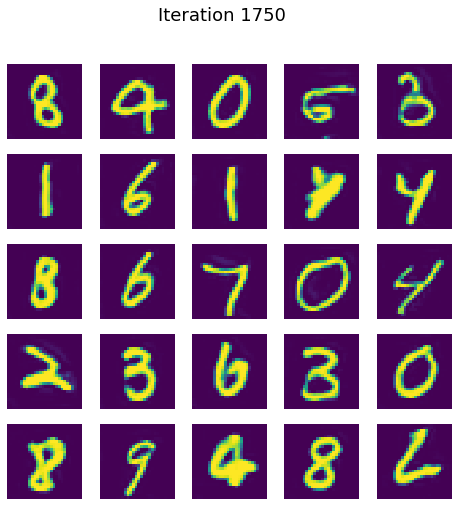

In [33]:
from IPython.display import clear_output
for k in range(6):
    #start with hacking the given generator
    discriminator = give_new_disc()
    optimizer_discriminator = \
    torch.optim.RMSprop(discriminator.parameters(), lr=0.001)
    disc_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_discriminator, step_size=10, gamma=0.999)
    generator.eval()
    for i in range(6000):
    # Set our models to training mode:
        discriminator.train()
        disc_scheduler.step()
  
    # Sampling reals and fakes
        real = sample_images(BATCH_SIZE, train_leak)
        fake = sample_fake(BATCH_SIZE)
    
    # Calculating the loss
        discriminator_loss_this_iter = discriminator_loss(real, fake) + \
                                   discriminator_penalty(real)
    
    # Doing our regular optimization step for the discriminator
        optimizer_discriminator.zero_grad()
        discriminator_loss_this_iter.backward()
        optimizer_discriminator.step()
    
        losses[i % VALIDATION_INTERVAL] = discriminator_loss_this_iter

        if i % SAVE_INTERVAL == 0:
            torch.save(generator, GENERATOR_FILE)
            torch.save(discriminator, DISCRIMINATOR_FILE)
    
        if i % VALIDATION_INTERVAL == 0:
            clear_output(wait=True)
            plt.plot(np.log(losses))
            plt.show()
            
    make_a_test(k)
    make_another_test(k)
    #do classical GAN learning using the generator made in the prevoius loop
    for i in range(2000):
          # Set our models to training mode:
        generator.train()
        discriminator.train()
        gen_scheduler.step()
        disc_scheduler.step()
  
        # Several discriminator updates per step:
        for j in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
                # Sampling reals and fakes
                real = sample_images(BATCH_SIZE)
                fake = sample_fake(BATCH_SIZE)
    
                # Calculating the loss
                discriminator_loss_this_iter = discriminator_loss(real, fake) + \
                                   discriminator_penalty(real)
    
            # Doing our regular optimization step for the discriminator
                optimizer_discriminator.zero_grad()
                discriminator_loss_this_iter.backward()
                optimizer_discriminator.step()

  

          # Now it's generator's time to learn:
        generator_loss_this_iter = generator_loss(sample_fake(BATCH_SIZE))

        optimizer_generator.zero_grad()
        generator_loss_this_iter.backward()
        optimizer_generator.step()

        if i % SAVE_INTERVAL == 0:
                torch.save(generator, GENERATOR_FILE)
                torch.save(discriminator, DISCRIMINATOR_FILE)
    
        if i % VALIDATION_INTERVAL == 0:
                clear_output(wait=True)
                generator.eval()
                imgs = sample_fake(25).cpu().detach().numpy()
                plot_images(imgs.clip(0, 1), title='Iteration '+str(i));
                plt.show();
    

Above one can see either a graph of the discriminator log-loss or a sample generated by the generator.

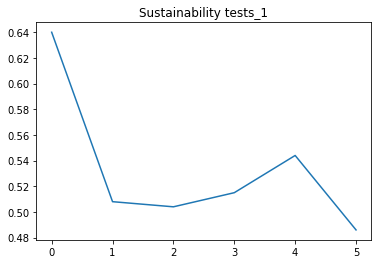

In [34]:
plt.plot(totals)
plt.title("Sustainability tests_1")
plt.show()

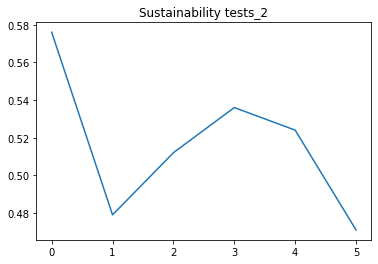

In [35]:
plt.plot(totals_2)
plt.title("Sustainability tests_2")
plt.show()

The first graph is accuracy metric on a balanced sample containing only elements from train dataset and generated elements.
The second graph is accuracy metric on a sample which contains elements from test dataset as well as generated elements. The share of elements from train ataset is one half in both cases.

According to both the graphs, the network has become significantly more sustainable to white-box attacks.